In [139]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error , mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import Dense,Activation,Dropout,Input,LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [140]:
df = pd.read_csv(r"D:\python_jupty\機器學習作業\大里補值完.csv")

<Figure size 1000x1000 with 0 Axes>

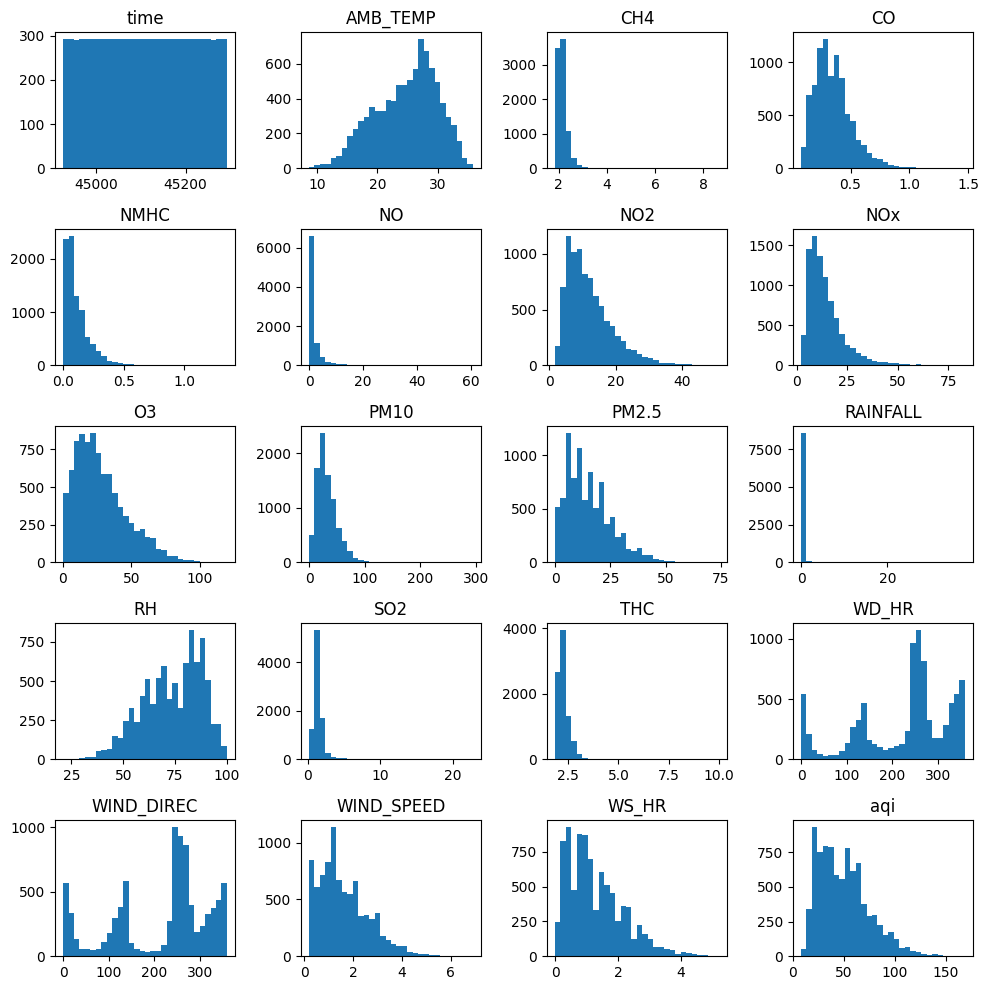

In [141]:
plt.figure(figsize=(10,10))
df.hist(bins=30, figsize=(10, 10), grid=False)
plt.tight_layout()
plt.show()

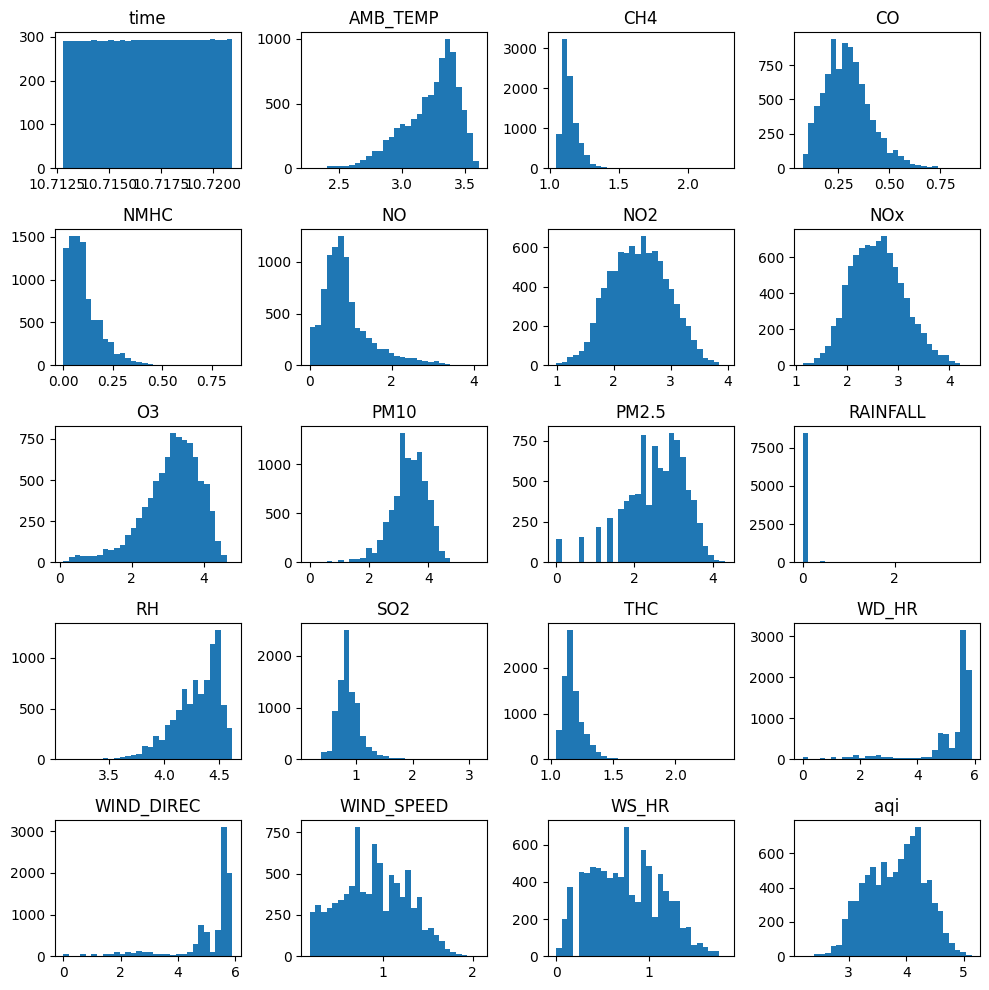

In [142]:
df_trans = df.transform(lambda x: np.log(x + 1))


df_trans.hist(bins=30, figsize=(10, 10), grid=False)
plt.tight_layout()
plt.show()

In [143]:
df_selected = df_trans.drop(columns=['time','WIND_DIREC','WD_HR','WIND_SPEED','NOx','WS_HR','RAINFALL','RH','AMB_TEMP','CH4','NMHC','NO','THC','O3','SO2'], inplace=False)
sel_data = 'aqi'  

In [144]:
df_selected.columns

Index(['CO', 'NO2', 'PM10', 'PM2.5', 'aqi'], dtype='object')

In [145]:
import math

train_len = math.ceil(len(df_trans) * 0.8)
test_len = len(df_trans) - train_len
print(test_len)
time_steps = 8
train,test = df_selected.iloc[0:train_len],df_selected.iloc[(train_len):len(df_trans)]
test_true = df['aqi'].iloc[(train_len):len(df_trans)]

1752


In [146]:
train_temp = train.to_numpy()
test_temp = test.to_numpy()

scaler = MinMaxScaler(feature_range=(0, 0.9))

train_np= scaler.fit_transform(train_temp)
test_np= scaler.fit_transform(test_temp)

In [147]:
from tqdm import tqdm
X_train = []
y_train = []

for i in tqdm(range(len(train_np) - time_steps)):
    X_train.append(train_np[i:i+time_steps])
    y_train.append(train_np[i+time_steps])

X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape)
print(y_train.shape)

100%|██████████| 7001/7001 [00:00<00:00, 1402843.60it/s]

(7001, 8, 5)
(7001, 5)


In [148]:
x_test = []
y_test = []
y_test_true = []


for i in tqdm(range(len(test_np)-time_steps)):
    x_test.append(test_np[i:i+time_steps])
    y_test.append(test['aqi'].iloc[i+time_steps])
    y_test_true.append(test_true.iloc[i+time_steps])
   

x_test = np.array(x_test)
y_test = np.array(y_test)
y_test_true = np.array(y_test_true)
print(x_test.shape)
print(y_test.shape)
print(y_test_true.shape)

100%|██████████| 1744/1744 [00:00<00:00, 116308.37it/s]

(1744, 8, 5)
(1744,)
(1744,)


In [149]:
opt = keras.optimizers.Adam(learning_rate=0.005)


model = Sequential()
model.add(Input(shape=(X_train.shape[1],  X_train.shape[2])))  

model.add(LSTM(32,return_sequences=True,activation='relu') )
model.add(LSTM(16,return_sequences=False,activation='relu') )
 
model.add( Dense(X_train.shape[2],activation='relu') )
model.compile(optimizer=opt, loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)


model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 8, 32)          │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,085 (31.58 KB)

 Trainable params: 8,085 (31.58 KB)

 Non-trainable params: 0 (0.00 B)

In [150]:

tt = 50
history = model.fit(X_train,y_train,batch_size=20,validation_split=0.1,epochs=tt,callbacks=[es],verbose=1,shuffle=False)

Epoch 1/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0989 - val_loss: 0.0803
Epoch 2/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0872 - val_loss: 0.0789
Epoch 3/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0863 - val_loss: 0.0767
Epoch 4/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0704 - val_loss: 0.0634
Epoch 5/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0666 - val_loss: 0.0612
Epoch 6/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0658 - val_loss: 0.0057
Epoch 7/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069 - val_loss: 0.0040
Epoch 8/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 9/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 10/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 11/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 12/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [216]:
import random

j = random.randint(0, 150)

initial_sequence = []
initial_sequence.append(test_np[j:j+time_steps])
initial_sequence = np.array(initial_sequence)

In [217]:
sequence = []
temp = X_train.shape[2]
for i in range(8):
    new_prediction = model.predict(initial_sequence)

    initial_sequence = initial_sequence[0][1:]
    
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0).reshape(-1,time_steps,X_train.shape[2])
    sequence.append(new_prediction[0][temp-1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [218]:
sc = MinMaxScaler(feature_range=(0, 0.9))
y_test= y_test.reshape(-1, 1)
sc.fit(y_test)

sequence = sc.inverse_transform(np.array(sequence).reshape(8,1))



In [219]:
sequence =np.exp(sequence) - 1
sequence = sequence.astype(int)

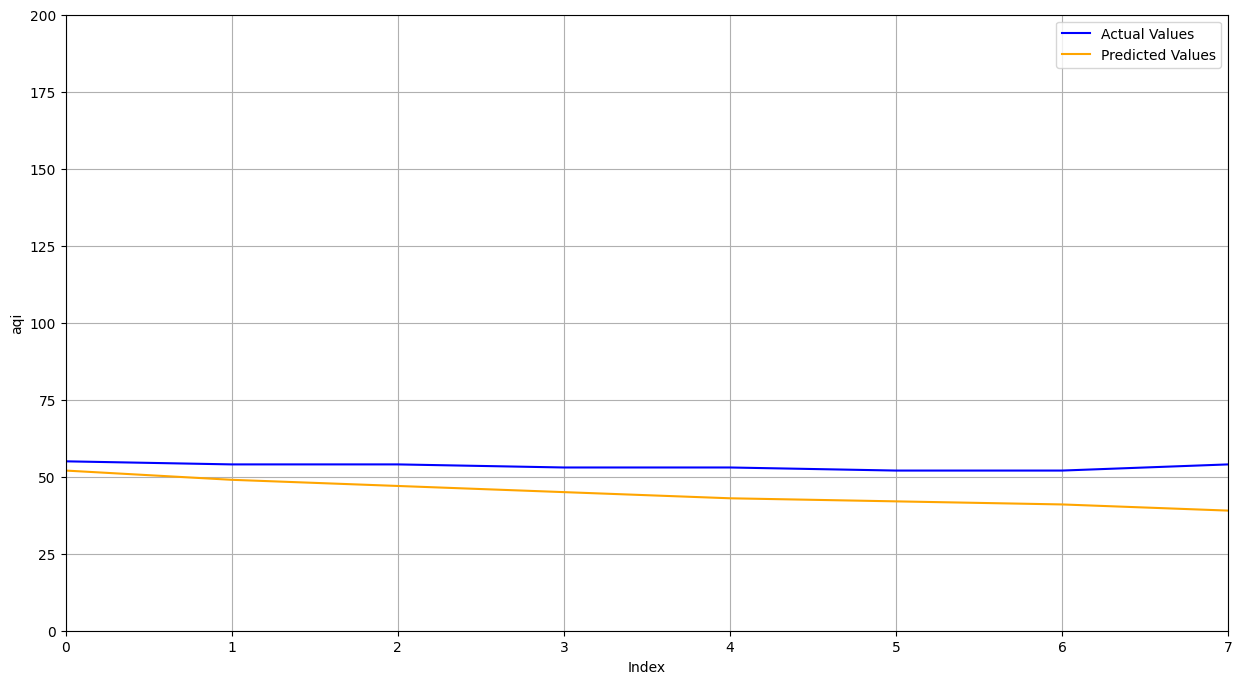

In [220]:
num_steps_to_show = 8
plt.figure(figsize=(15, 8))
plt.plot(y_test_true[j+time_steps:j+time_steps+time_steps], label='Actual Values', color='blue', linestyle='-')
plt.plot(sequence[:num_steps_to_show], label='Predicted Values', color='orange', linestyle='-')
plt.xlim(0, 7) 
plt.ylim(0, 200) 
plt.xlabel('Index')
plt.ylabel('aqi')
plt.legend()
plt.grid(True)
plt.show()